## Empirical Interpolation Method for a non-affine parameter in a potential

Let's consider the following potential with Woods-Saxon form:

\begin{equation}
    V(r;R,a) = -\frac{V_0}{1 + \exp{\frac{r-R}{a}}}.
\end{equation}

We would like to vary $R$, $a$, and/or the momentum; $p$. For now, let's focus our attention on just $R$. First, let's apply the scaling. We now have:

\begin{equation}
  U(s,p;S,z) = -\frac{ 2 \mu V_0 }{ p^2}  \frac{1}{ (1 + \exp{ \frac{s-S}{ z }})},
\end{equation}

where we've defined $S = R p$ and $z = a p$.

Notice how our parameters of interest are distincively non-affine; for example: $U(s,p; S + S', \tilde{a}) \neq U(s,p; S, \tilde{a}) + U(s,p; S', \tilde{a})$. If we want to construct an RBM with which we can perturb $S \rightarrow S'$, we will not be able to simply construct an affine space of scattering wavefunctions with a set of training points $T = \{ S_1, S_2, ..., S_N \}$ as before. Unless perhaps we could find an approximation of $U$ (let's call it $\tilde{U}$), that was affine in $S$ ...

\begin{equation}
U(s; S)  \approx \tilde{U}(s; S)  = \sum_k^M \beta_k(S) U_k(s) 
\end{equation}

... yeah, something like that! Here, we denote $U_k(s) = U(s,S_k)$ as a "snapshot", or training point, of $U(s; S)$, evaluated at particular values $S = S_k$ ($z$ and $p$ will be fixed, so we will suppress dependence upon them going forward). $\tilde{U}(s;S)$ should interpolate $U(s;S)$ between the training points $T$.

Already, we see an analogy with what we did before in the space of wavefunctions, but now in the space of operators $U(s;S)$: we will evaluate $N$ snapshots of $U(s;S)$, with $S$ evaluated at each value on the training space $T$, which we are free to choose. As before, we will then do PCA to find $M < N$ dimensions that suitably encapsulate the information content of $U(s;S)$ as we vary $S \in T$. 

Then, we can simply plug our $M$ snapshots, $U_k(s)$ into the equation that enforces our desired interpolation:

\begin{equation}
U(s; S) = \sum_k^M \beta_k(S) U_k(s).
\end{equation}

We'll maybe not so simply, but we'll burn that bridge when we get to it. For now, let's build our training space.

First, define our constantns and potentials:

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

hbarc = 197 # MeV • fm
mass = 939 # MeV
energy = 50 # center-of-mass scattering energy, fixed for the first example
k = np.sqrt(mass*energy)/hbarc

In [21]:
def woods_saxon(r, args):
    V0, R, a = args
    return -V0/(1. + np.exp((r-R)/a))
    
def woods_saxon_tilde(s, args):
    return 1./energy * woods_saxon(s/k, args)

# interaction parameters we will use for testing
V0 = 200 # MeV
a  = 0.5 # fm

In [22]:
# create N points, distributed evenly, on our desired range
# it is inexpensive to simply evaluate a potential, so might as well 
# use a large number of training points
N = 1000

# let's take a physical range
R_min = 4
R_max = 5
T = np.arange(R_min, R_max, (R_max - R_min)/N) 
#T = generate_rand_log(np.log(R_min), np.log(R_max), N=N)

In [23]:
def Utrain(s):
    """
    Takes in an array of s values, spits out a matrix of the Woods-Saxon reduced potential
    evaluated at those s and each S value on T
    """
    tmp = np.zeros(np.outer(s,T).shape)
    TT = tmp + T 
    SS = tmp.T + s
    return np.array([ woods_saxon_tilde(SS.T, (V0, TT, a)) ])[0].T

In [24]:
s_endpts = k * np.array([1e-6, 20]) # dimensionless
s = np.linspace(*s_endpts, 2000)
r = s/k

Umat = Utrain(s)

Text(0, 0.5, '$U$ [a.u.]')

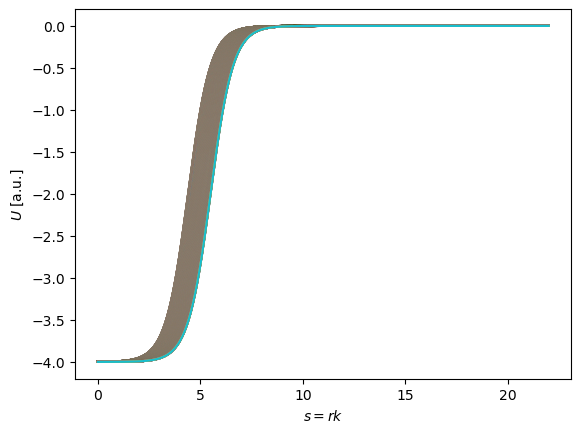

In [25]:
for i in range(N):
    plt.plot(s, Umat[i,:])
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")

Great, we have a healthy training set of potentials. We would expect that the diffraction minima in differential elastic scattering cross sections, for example, to be quite sensitive to the $R$ value of a Woods-Saxon potential. In other words, all those potentials would produce very different cross-sections! Now let's do PCA and keep just the few that encapsulate most of this information.


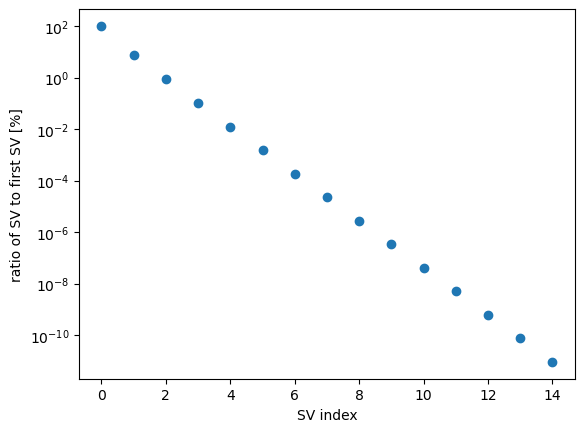

In [26]:
# how big is our final basis?
U, S, Vt = np.linalg.svd(Umat.T, full_matrices=False)
plt.semilogy(100*S[:15]/S[0], "o", linestyle="None")
plt.xlabel("SV index")
plt.ylabel("ratio of SV to first SV [%]")
plt.show()

These singular values are dropping nicely; let's take only the first few. 

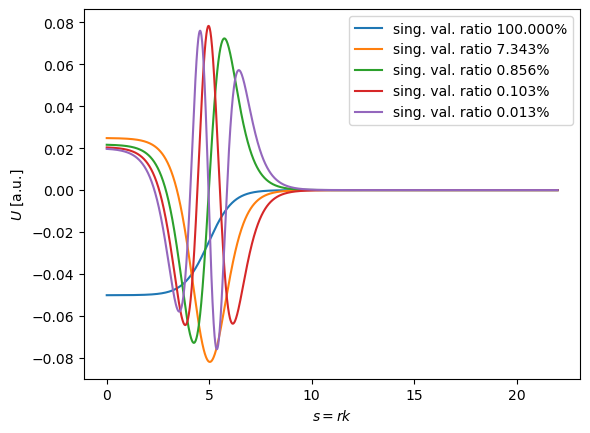

In [27]:
M = 5 # definitely less than N!
for i in range(M):
    plt.plot(s, U[:,i], label="sing. val. ratio {:1.3f}%".format(100*S[i]/S[0]))
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
plt.legend()
plt.show()

U = U[:,:M]

Great, we have our basis $U_k(s)$. We only need $M$ elements to represent most of the information encapsulated in our training set! Now we would like to determine our $M$ coefficients, $\beta_k(S)$. If we evaluate the interpolation equation at $M$ values of $s$, we have $M$ equations, which pairs quite nicely with our $M$ unknown coefficients. But what values of $s$ should we choose? 

Intuitively, we should choose the $s$ values which provide the most information - the places where the variance in potential values between the different parameters is highest. Let's take a look at the standard deviation of our training set as a function of $s$:

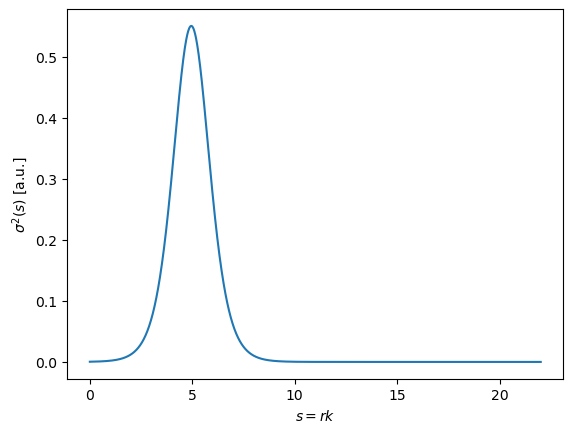

In [28]:
plt.plot(s, np.sqrt(np.var(Umat, axis=0)) )
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$\sigma^2(s)$ [a.u.]")
plt.show()

As a first pass, let's consider two simple ways of choosing our $M$ points, $s_k$.

1. Sampling from the variance distribution
3. uniformly and linearly sampling the range [0,10]

Explore these methods below, or alternatively, hand-pick your own training points to study the sensitivity of the EIM to your choice. Notice the downside of method 1.: for small $M$, the accuracy of the solution can be very sensitive to random noise, but it produces a good solution on average. What if, instead of independently sampling all $M$ points according to the variance, we were to sample each point sequentially, to optimize the variance conditional on the locations of the previous points? This is the essence of the greedy algorithm, which is not yet covered in this section.

In [29]:
ps = np.sqrt(np.var(Umat, axis=0))

# normalize
ps /= np.trapz(ps, x=s)
ps /= np.sum(ps)

# change this to try method 1 or 2 defined above
sample_from_variance = True

if sample_from_variance:
    sample_pts = np.random.choice(s, size=M, p=ps)
else:
    sample_pts = np.linspace(0.1,10,M)
    

In [30]:
sample_pts


array([5.62328036, 4.69890569, 3.917589  , 5.9754231 , 6.0304454 ])

Once we have chosen the sample points one way or another, we can simultaneously solve our interpolation equation at those points. We know want to solve an equation of the form

\begin{equation}
\mathbf{A} \overline{x}(S) = \overline{b}(S),
\end{equation}

where 

\begin{equation}
{b}_{j} = U(s_j,S),
\end{equation}
and 
\begin{equation}
{A}_{jk} = U_j(s_k),
\end{equation}

and our unkown coefficient functions,
\begin{equation}
{x}_{k} = \beta_k(S).
\end{equation}

In [31]:
A = np.zeros((M,M))
for j in range(M):
    A[:,j] = np.interp( sample_pts, s, U[:,j])

Let's take a look at our potential evaluated at our $M$ chosen sample points, over the range of $S$ values in $T$.

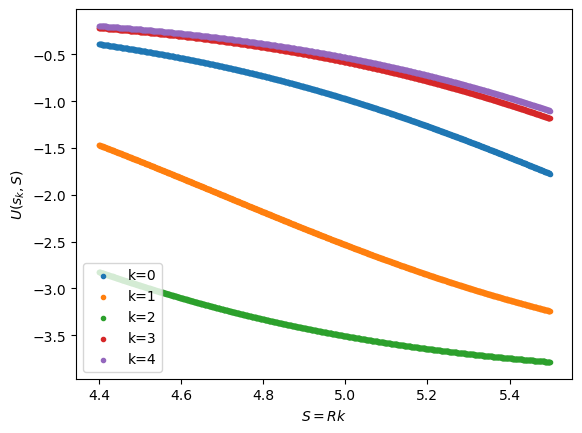

In [32]:
b = np.zeros((M,N))
for ki in range(M):
    b[ki,:] = woods_saxon_tilde(sample_pts[ki], (V0, T, a))
    plt.scatter(k*T, woods_saxon_tilde(sample_pts[ki], (V0, T, a)), 
                marker='.', label="k={}".format(ki))
plt.xlabel(r"$S = R k$")
plt.ylabel(r"$U(s_k,S)$")
plt.legend()
plt.show()

In [33]:
# solve the system to find the coefficient functions
x = np.einsum('jk,k...', np.linalg.inv(A), b)

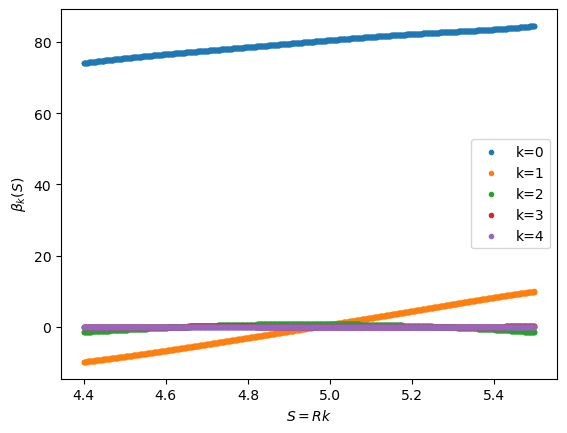

In [34]:
for j in range(M):
    plt.scatter(k*T, x[:,j],  marker='.', label="k={}".format(j))
plt.xlabel(r"$S = Rk$")
plt.ylabel(r"$\beta_k(S)$")
plt.legend()
plt.show()

Intuitively, we see that the coefficients generally decrease in magnitude with the singular value, which is a good sanity check. Now let's put it all together to test our affine decomposition of the potential.

In [35]:
def beta(S):
    betas = np.zeros(M)
    for i in range(M):
        betas[i] = np.interp(S, k*T, x[:,i])
    return betas

def ws_affine_decomp(s, args, T):
    '''
    affine decomposition of our Woods-Saxon potential
    '''
    V0, R, a = args
    S = R*k
    
    betas = beta(S)
    Uad   = np.sum(betas * U, axis=1)
        
    return Uad

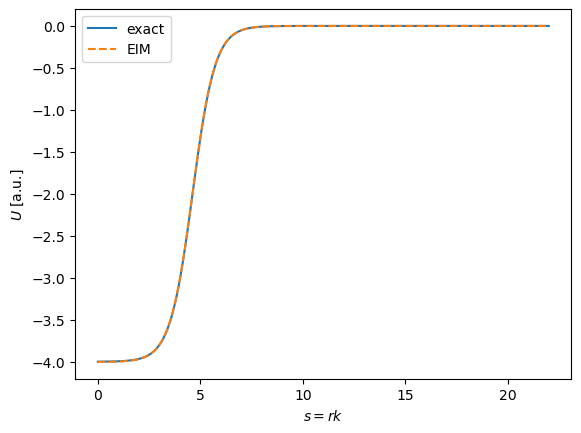

In [36]:
R_test = 4.2
plt.plot(s, woods_saxon_tilde(s, (V0, R_test, a)),  label="exact")
plt.plot(s, ws_affine_decomp(s, (V0, R_test, a), T), '--', label="EIM")

plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
plt.legend()
plt.show()

Nice! By messing with the choice of sample points, we can see this method is very sensitive to the choice. This motivates the need for a greedy algorithm that can optimally choose the next sample point to maximize the variance, conditional on the initial set.

Another thing to notice is that the method fails to extrapolate; if $R_{test} \notin [R_{min}, R_{max}]$ we visually see poor agreement.

# Building the RBM for the affinely-decomposed problem

Now that we have our affine decomposition for the Woods-Saxon potential, we can use it in a scattering RBM. First, we will select a new, smaller, set of training points, and calculate solutions for each one. We will borrow most of the RBM machinery from the previous section, with a few key differences that we will highlight.

In [37]:
initial_conditions = np.array([0.0, 1.0]) # initial phi(0) and phi'(0) conditions

def solve_se(theta):
    result = solve_ivp(
        lambda s, phi: np.array([phi[1],
            (woods_saxon_tilde(s, theta) + l*(l+1)/s**2 - 1.0) * phi[0]]),
        s_endpts, initial_conditions, rtol=1e-12, atol=1e-12, dense_output=True
    )
    phi = result.sol(s)[0, :]
    return s, phi

Now we construct our training basis:

In [38]:
#We create 10 linearly spaced values of the linear parameters and solve the high fidelity problem 10 times
n_train_pts = 20


# Only consider the s-waves
l = 0

# construct RB training set
training_set = np.linspace(R_min, R_max, n_train_pts)
print(training_set)
training_points = np.array([
    (V0, R_train, a) for R_train in  training_set
])

# construct RB
training_solutions = np.array(
    [solve_se(theta)[1] for theta in training_points]
).T

# add free wave soln to RB, subtract from other basis elements
phi_0 = solve_se(np.array([0, 0, 0]))[1]

training_solutions_sub = np.zeros_like(training_solutions.T)

for i in range(training_solutions.shape[1]):
    training_solutions_sub[i,:] = training_solutions.T[i,:].copy() - phi_0
    

[4.         4.05263158 4.10526316 4.15789474 4.21052632 4.26315789
 4.31578947 4.36842105 4.42105263 4.47368421 4.52631579 4.57894737
 4.63157895 4.68421053 4.73684211 4.78947368 4.84210526 4.89473684
 4.94736842 5.        ]


/tmp/ipykernel_20206/2263952121.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return -V0/(1. + np.exp((r-R)/a))


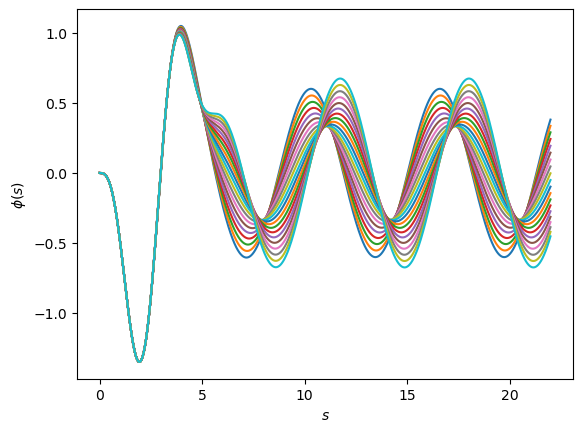

In [39]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for u in training_solutions_sub:
    ax.plot(s, u)

ax.set_ylabel(r'$\phi(s)$')
ax.set_xlabel(r'$s$');

Now, let's construct our RBM, selecting only the important information from our preliminary basis with PCA.

In [40]:
U_rb, S_rb, _ = np.linalg.svd(training_solutions_sub.T, full_matrices=False)

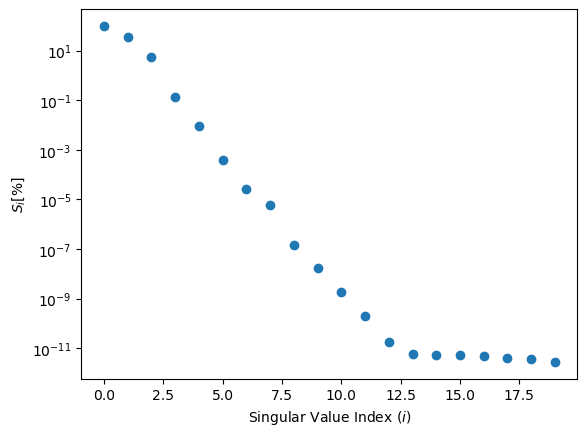

In [41]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S_rb.size), S_rb/S_rb[0]*100)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i [\%]$');

In [42]:
nbasis = 4

# we finally have our reduced basis
rb = U_rb[:,:nbasis]

# as before, we choose this basis to be our Galerkin projectors
psi = rb

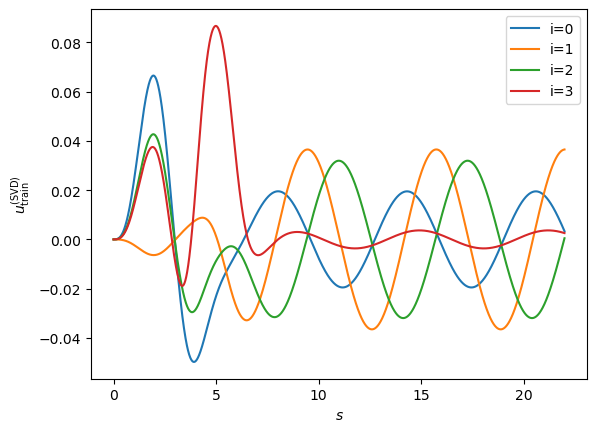

In [43]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(nbasis):
    ax.plot(s, rb[:, i], label="i={}".format(i))

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');
plt.legend()

Excellent! We have our reduced basis $\{ \psi_i \}$. We will use the reduced basis itself as our Galerkin projectors, so we would like to simply project our operator into the reduced basis, calculating the low-dimensional matrix $\mathbf{F}(S)$: 

\begin{equation}
{F}(S)_{ij} =  \langle \psi_i | \left[ -\frac{d^2}{ds^2}+\frac{\ell(\ell+1)}{s^2}+U(s; S)-1 \right] | \psi_j \rangle,
\end{equation}

and solve the inhomogenous matrix equation:
\begin{equation}
\mathbf{F}(S) \vec{\phi} = 0,
\end{equation}

where $\vec{\phi}$ holds the coefficients for expanding our solution in the reduced basis:

\begin{equation}
| \phi \rangle = \sum_i \vec{\phi}_i  \psi_i
\end{equation}

Now, however, instead of using Woods-Saxon $  U(s;S) $ defined above, we have to use our affine decomposition $\tilde{U}(s; S)  = \sum_k^M \beta_k(S) U_k(s) $. We define $\tilde{\mathbf{F}}(S) \approx \mathbf{F}(S)$ as follows:

\begin{equation}
\tilde{F}(S)_{ij} =  \langle \psi_i | \left[ -\frac{d^2}{ds^2}+\frac{\ell(\ell+1)}{s^2} + \sum_k^M \beta_k(S) U_k(s)-1 \right] | \psi_j \rangle.
\end{equation}

We need to calculate the matrix elements $\langle \psi_i | U_k(s) | \psi_j \rangle$ . Then, for any value of $S$, we can simply grab our coefficients from the functions $\beta_k(S)$ that we calculated, do the weighted sum, and we have our projected potential! 

Note: because we added $\phi_0$, the free solution, to our basis set, our projected equation approximating $\mathbf{F}(S) \vec{\phi} = 0$ gets an inhomogenous term. We now have:


\begin{equation}
\tilde{F}(S)_{ij} \psi_i = \langle \psi_j | F(S) | \phi_0 \rangle.
\end{equation}

In the code below, we make the definitions $A_{ij} = \tilde{F}(S)_{ij}$ and $b_j = \langle \psi_j | F(S) | \phi_0 \rangle$, resulting in the matrix equation $\mathbf{A} \vec{\psi} = \vec{b}$, where the elements of $\vec{\psi}$ are the coefficients of the emulated solution in the reduced basis.

We will use the same affine decomposition on the RHS as we did on the LHS. Let's see how that looks below:

In [44]:
# pre-compute matrix elements of affinely-decomposed Woods-Saxon
# NOTE: real application should use something like np.trapz to integrate over s -
# not sure how to do that 'pythonically'

# U_proj[k,i,j]  == <psi_i(s) | U_k(s) | psi_j(s) > 
U_proj = np.einsum('si,sj,sk', U, np.conj(rb) , rb)


# matrix element for inhomogenous term
# U_0[k,i]  == <psi_i(s) | U_k(s) | phi_0(s) >
U_0 = np.einsum('si,sj,s', U, np.conj(rb) , phi_0)


We can also precompute the other terms in $\tilde{\mathbf{F}}(S)$ in the exact same way as the previous section:

In [45]:
# pre-compute matrix elements of the rest of F, as in the previous section (leave out potential contribution for now)
# matrix element of derivative, angulat momentum, and norm/identity (e.g. <psi_j | psi_i> ) components
A = psi.T @ (
             - np.gradient(np.gradient(rb, s, axis=0), s, axis=0)  
             + np.einsum('s,s...', l*(l+1)/(s*s) , rb) 
             - rb
            )

# matrix element of inhomogenous term
b = -psi.T @ (
                - np.gradient(np.gradient(phi_0, s), s) 
                + l*(l+1)/(s*s) * phi_0 
                - phi_0
             )

Now that all of our matrix elements are precomputed, given a value for $S$ we care to find a solution for, we construct a matrix problem $\mathbf{A} \vec{x} = \vec{b}$ in the reduced basis, and solve it!

In [46]:
def rbm_emulator(S):
    '''
    Given an S value, appropriately constructs the reduced basis operator from a weighted (by beta_k(S))
    sum of the pre-computed matrix elements, and solved the Aa=b system. 
    Returns the coefficients projected onto the reduced basis
    '''
    betas = beta(S)
    
    # potential contributions to A, summing over the M EIM basis functions 
    # beta_k(S) * <psi_j(s) | U_k(s) | psi_i(s) >
    A_pot = np.einsum('k,k...', betas , U_proj)
    b_pot = np.einsum('k,k...', betas , U_0)

    return np.linalg.solve(A + A_pot, b - b_pot)

In [47]:
# now let's test it out
R_test = 4.4
emu_proj = rbm_emulator(R_test*k)
emu_proj

array([-19.28975348,   2.19196662,  -1.1881938 ,  -0.03193266])

In [48]:
emu = np.sum(emu_proj * rb, axis=1) + phi_0
exact = solve_se((V0, R_test, a))[1]

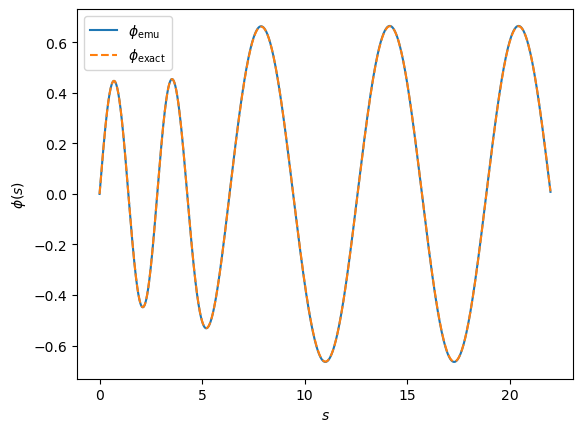

In [49]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.plot(s, emu, linestyle='-', label=r'$\phi_{\rm emu}$')
ax.plot(s, exact, linestyle='--', label=r'$\phi_{\rm exact}$')

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$\phi(s)$')
ax.legend();

Not bad!